In [ ]:
!nvidia-smi

# Load Data

In [2]:
%%capture
!pip install transformers

In [ ]:
!pip install pytorch-lightning

In [10]:
import os
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
drive.mount("/content/drive", force_remount=False)

Mounted at /content/drive


In [5]:
train_path = "/content/drive/MyDrive/Colab Notebooks/Pytorch/Text Classification/uc_data/train.csv"
val_path = "/content/drive/MyDrive/Colab Notebooks/Pytorch/Text Classification/uc_data/val.csv"

In [ ]:
train_data = pd.read_csv(train_path)
train_data.head()

# Inspect Data

In [7]:
train_data.columns

Index(['_unit_id', '_trusted_judgments', 'comment', 'antagonize',
       'antagonize:confidence', 'condescending', 'condescending:confidence',
       'dismissive', 'dismissive:confidence', 'generalisation',
       'generalisation:confidence', 'generalisation_unfair',
       'generalisation_unfair:confidence', 'healthy', 'healthy:confidence',
       'hostile', 'hostile:confidence', 'sarcastic', 'sarcastic:confidence'],
      dtype='object')

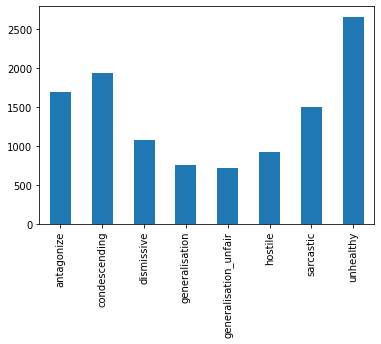

In [11]:
train_data['unhealthy'] = np.where(train_data['healthy'] == 1, 0, 1)
attributes = ['antagonize','condescending','dismissive','generalisation','generalisation_unfair',
              'hostile', 'sarcastic', 'unhealthy']
train_data[attributes].sum().plot.bar();

In [15]:
train_data[attributes].loc[train_data[attributes].sum(axis=1) > 0]

,antagonize,condescending,dismissive,generalisation,generalisation_unfair,hostile,sarcastic,unhealthy
13,0,0,0,0,0.0,0,0,1
17,0,1,1,0,0.0,0,0,0
22,0,0,0,1,1.0,0,0,0
30,1,1,1,0,0.0,1,0,1
36,0,0,0,0,0.0,0,1,0
...,...,...,...,...,...,...,...,...
35474,0,1,0,0,0.0,0,0,0
35475,0,0,0,0,0.0,0,1,1
35480,0,1,0,0,0.0,0,0,0
35488,0,0,0,0,0.0,0,1,0


# Datasets - Preprocess

In [12]:
from torch.utils.data import Dataset

In [22]:
import torch
from pandas.core.common import random_state
class UCC_Dataset(Dataset):
  def __init__(self, data_path, tokenizer, attributes, max_token_len: int = 128, sample = 5000):
    self.data_path = data_path
    self.tokenizer = tokenizer
    self.attributes = attributes
    self.max_token_len = max_token_len
    self.sample = sample
    self._prepare_data()

  def _prepare_data(self):
    data = pd.read_csv(self.data_path)
    data['unhealthy'] = np.where(data['healthy'] == 1, 0, 1)
    if self.sample is not None:
      unhealthy = data.loc[data[attributes].sum(axis=1) > 0]
      healthy = data.loc[data[attributes].sum(axis=1) == 0]
      self.data = pd.concat([unhealthy, healthy.sample(self.sample, random_state=7)])
    else:
      self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    item = self.data.iloc[index]
    comment = str(item.comment)
    attributes = torch.FloatTensor(item[self.attributes])
    tokens = self.tokenizer.encode_plus(comment, 
                                        add_special_tokens=True, 
                                        return_tensors='pt', 
                                        truncation = True,
                                        max_length=self.max_token_len,
                                        padding='max_length',
                                        return_attention_mask=True)
    return {
        'input_ids': tokens.input_ids.flatten(), 
        'attention_mask': tokens.attention_mask.flatten(), 
        'labels': attributes
    }


In [23]:
from transformers import AutoTokenizer
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
ucc_ds = UCC_Dataset(train_path, tokenizer, attributes)
ucc_ds_val = UCC_Dataset(val_path, tokenizer, attributes, sample=None)

In [24]:
ucc_ds.__getitem__(0)

{'input_ids': tensor([    0, 19897, 29846,     4,    38,    64,    75,   679, 46301,    74,
          9802,   132,     9,    39,   308,    95,     7,  1471,   559,   332,
             8,   146,  7064,   356,  1099,     4,   370,   214,   235,     6,
         46301,    16,    10, 34759,     4,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [25]:
ucc_ds_val.__getitem__(0)

{'input_ids': tensor([    0,  1711,    18,  2230,    99,    51,   348,   626,     4, 10911,
             6,  2177,    18,   144,  1406,  9955,   138,     6,  1523,    41,
          1553,     4,   404,    49, 27746,    32, 10059, 27746,    19,  9955,
         12957, 11129, 24194,     4,     2,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [27]:
len(ucc_ds), len(ucc_ds_val)

(9960, 4427)

# Data Module - Data setup for model

In [30]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader

In [45]:
class UCC_Data_Module(pl.LightningDataModule):

  def __init__(self, train_path, val_path, attributes, batch_size: int = 16, max_token_length: int = 128,  model_name='roberta-base'):
    super().__init__()
    self.train_path = train_path
    self.val_path = val_path
    self.attributes = attributes
    self.batch_size = batch_size
    self.max_token_length = max_token_length
    self.model_name = model_name
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)

  def setup(self, stage = None):
    if stage in (None, "fit"):
      self.train_dataset = UCC_Dataset(self.train_path, attributes=self.attributes, tokenizer=self.tokenizer)
      self.val_dataset = UCC_Dataset(self.val_path, attributes=self.attributes, tokenizer=self.tokenizer, sample=None)
    if stage == 'predict':
      self.val_dataset = UCC_Dataset(self.val_path, attributes=self.attributes, tokenizer=self.tokenizer, sample=None)

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers=4, shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=4, shuffle=False)

  def predict_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=4, shuffle=False)


In [46]:
train_path = '/content/drive/MyDrive/Colab Notebooks/Pytorch/Text Classification/uc_data/train.csv'
val_path = '/content/drive/MyDrive/Colab Notebooks/Pytorch/Text Classification/uc_data/val.csv'

In [47]:
ucc_data_module = UCC_Data_Module(train_path, val_path, attributes)

In [48]:
ucc_data_module.setup()

In [51]:
dl = ucc_data_module.train_dataloader()
len(dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


623

# Model

In [50]:
from transformers import AutoModel, AdamW, get_cosine_schedule_with_warmup
import torch.nn as nn
import math
from torchmetrics.functional.classification import auroc
import torch.nn.functional as F

In [52]:
class UCC_Comment_Classifier(pl.LightningModule):

  def __init__(self, config: dict):
    super().__init__()
    self.config = config
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
    self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
    self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
    torch.nn.init.xavier_uniform_(self.classifier.weight)
    self.loss_func = nn.BCEWithLogitsLoss(reduction='mean')
    self.dropout = nn.Dropout()
    
  def forward(self, input_ids, attention_mask, labels=None):
    # roberta layer
    output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = torch.mean(output.last_hidden_state, 1)
    # final logits
    pooled_output = self.dropout(pooled_output)
    pooled_output = self.hidden(pooled_output)
    pooled_output = F.relu(pooled_output)
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
    # calculate loss
    loss = 0
    if labels is not None:
      loss = self.loss_func(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']))
    return loss, logits

  def training_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("train loss ", loss, prog_bar = True, logger=True)
    return {"loss":loss, "predictions":outputs, "labels": batch["labels"]}

  def validation_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("validation loss ", loss, prog_bar = True, logger=True)
    return {"val_loss": loss, "predictions":outputs, "labels": batch["labels"]}

  def predict_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    return outputs

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
    total_steps = self.config['train_size']/self.config['batch_size']
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    return [optimizer],[scheduler]

  # def validation_epoch_end(self, outputs):
  #   losses = []
  #   for output in outputs:
  #     loss = output['val_loss'].detach().cpu()
  #     losses.append(loss)
  #   avg_loss = torch.mean(torch.stack(losses))
  #   self.log("avg_val_loss", avg_loss)
    

In [53]:
config = {
    'model_name': 'distilroberta-base',
    'n_labels': len(attributes),
    'batch_size': 128,
    'lr': 1.5e-6,
    'warmup': 0.2, 
    'train_size': len(ucc_data_module.train_dataloader()),
    'weight_decay': 0.001,
    'n_epochs': 100
}

model = UCC_Comment_Classifier(config)

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [54]:
idx=0
input_ids = ucc_ds.__getitem__(idx)['input_ids']
attention_mask = ucc_ds.__getitem__(idx)['attention_mask']
labels = ucc_ds.__getitem__(idx)['labels']
model.cpu()
loss, output = model(input_ids.unsqueeze(dim=0), attention_mask.unsqueeze(dim=0), labels.unsqueeze(dim=0))
print(labels.shape, output.shape, output)

torch.Size([8]) torch.Size([1, 8]) tensor([[ 0.0294, -0.3993,  0.8554,  0.1865,  0.7532, -0.3792,  0.0519,  0.3374]],
       grad_fn=<AddmmBackward0>)


# Train Model

In [ ]:
# datamodule
ucc_data_module = UCC_Data_Module(train_path, val_path, attributes=attributes, batch_size=config['batch_size'])
ucc_data_module.setup()

# model
model = UCC_Comment_Classifier(config)

# trainer and fit
trainer = pl.Trainer(max_epochs=config['n_epochs'], gpus=1, num_sanity_val_steps=50)
trainer.fit(model, ucc_data_module)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Traine

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs/

# Predict with model

In [ ]:
# method to convert list of comments into predictions for each comment
def classify_raw_comments(model, dm):
  predictions = trainer.predict(model, datamodule=dm)
  flattened_predictions = np.stack([torch.sigmoid(torch.Tensor(p)) for batch in predictions for p in batch])
  return flattened_predictions

In [ ]:
predictions = classify_raw_comments(model, ucc_data_module)

In [ ]:
val_data = pd.read_csv(val_path)
val_data['unhealthy'] = np.where(val_data['healthy'] == 1, 0, 1)
true_labels = np.array(val_data[attributes])

In [ ]:
from sklearn import metrics
plt.figure(figsize=(15, 8))
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      true_labels[:,i].astype(int), predictions[:, i])
  auc = metrics.roc_auc_score(
      true_labels[:,i].astype(int), predictions[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('RoBERTa Trained on UCC Datatset - AUC ROC')